## SVM e PCA per classificazione volti

In [50]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [51]:
from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

In [34]:
def plot_gallery(images, h, w, n_row=3, n_col=4, titles=None):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        if titles != None:
            plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

In [35]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

In [36]:
lfw_people.images.shape

(1288, 50, 37)

In [37]:
n_samples, h, w = lfw_people.images.shape

In [38]:
X = lfw_people.data

In [39]:
X.shape

(1288, 1850)

In [40]:
n_features = X.shape[1]

In [41]:
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

In [42]:
n_classes

7

In [43]:
print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


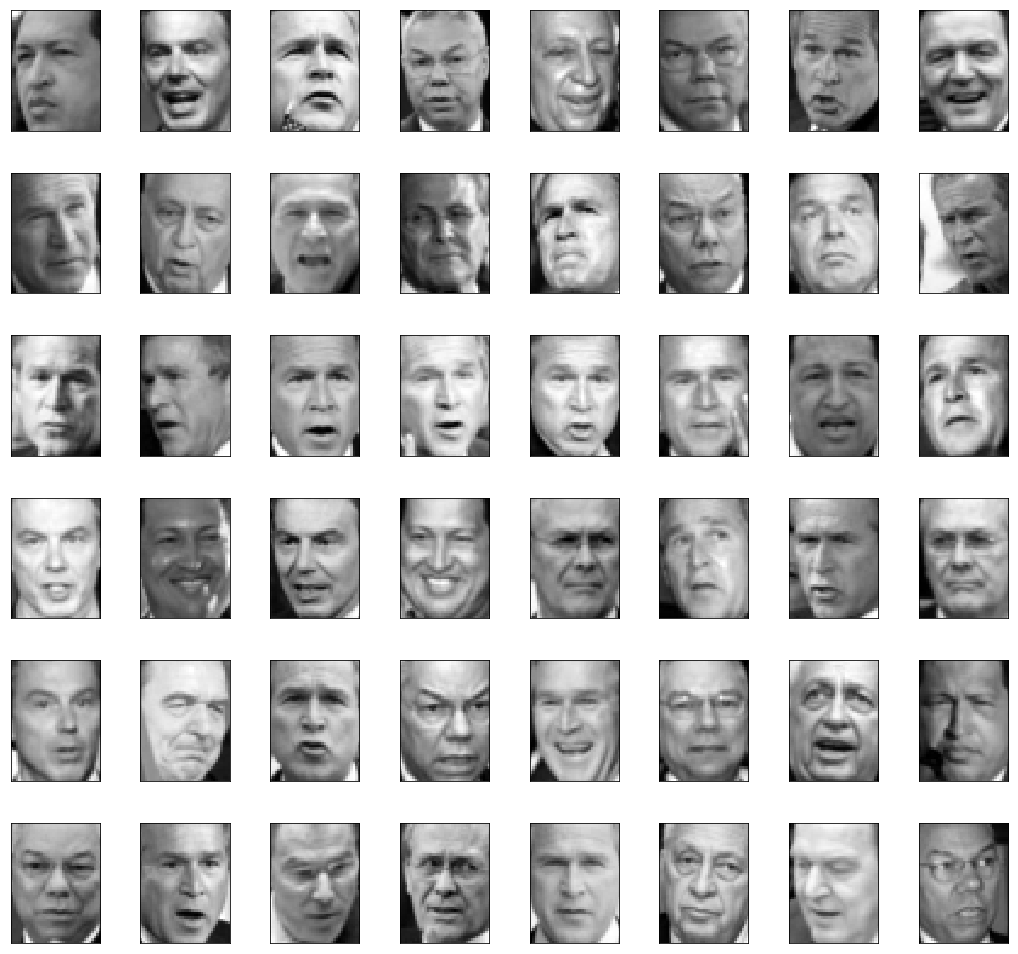

In [44]:
plot_gallery(X, h, w, n_row=6, n_col=8)

In [45]:
# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

Use PCA for dimensionality reduction

In [46]:
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

print("Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0]))
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_train)

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

Extracting the top 150 eigenfaces from 966 faces
Projecting the input data on the eigenfaces orthonormal basis


In [49]:
# Train a SVM classification model

print("Fitting the classifier to the training set")
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("Best estimator found by grid search:")
print(clf.best_estimator_)
print(clf.best_score_)

Fitting the classifier to the training set
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
0.7908902691511387


In [48]:
print("Predicting people's names on the test set")
y_pred = clf.predict(X_test_pca)

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Predicting people's names on the test set
                   precision    recall  f1-score   support

     Ariel Sharon       0.86      0.60      0.71        20
     Colin Powell       0.74      0.96      0.84        57
  Donald Rumsfeld       0.91      0.78      0.84        27
    George W Bush       0.85      0.92      0.88       131
Gerhard Schroeder       0.92      0.79      0.85        28
      Hugo Chavez       1.00      0.85      0.92        20
       Tony Blair       0.96      0.67      0.79        39

        micro avg       0.85      0.85      0.85       322
        macro avg       0.89      0.80      0.83       322
     weighted avg       0.86      0.85      0.85       322

[[ 12   3   1   4   0   0   0]
 [  2  55   0   0   0   0   0]
 [  0   2  21   4   0   0   0]
 [  0  10   0 121   0   0   0]
 [  0   0   1   4  22   0   1]
 [  0   1   0   1   1  17   0]
 [  0   3   0   9   1   0  26]]


In [42]:
# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

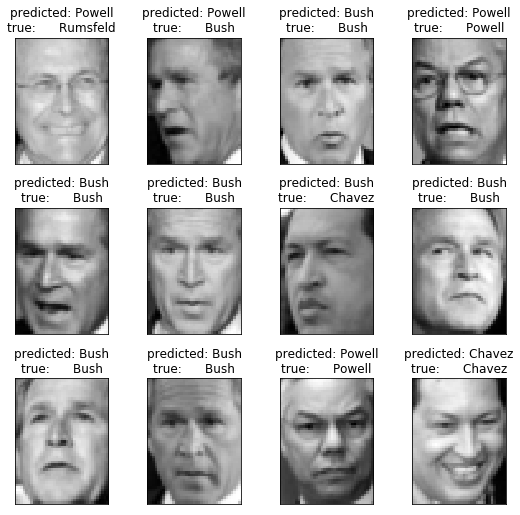

In [43]:
prediction_titles = [title(y_pred, y_test, target_names, i) for i in range(y_pred.shape[0])]

plot_gallery(X_test, h, w, titles=prediction_titles)